In [1]:
import h5py
import astropy.units as u
import numpy as np
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt

# Sample data with units (replace with your actual data)
# For example purposes, we're assuming some values
from astropy import units as u
fn = '/Users/wasi/Downloads/galaxy_galplane_l50_b0.hdf'

avail_fields = [
    'RA', 'DEC', 'longitude', 'latitude', 'distance', 'distance_mod',
    'age', 'mass', 'metallicity', 'vx', 'vy', 'vz',
    # Castor bands
    'CASTOR_u_app', 'CASTOR_uv_app', 'CASTOR_g_app',
    'CASTOR_u_split_bb_app', 'CASTOR_uv_split_bb_app',
    # LSST bands
    'LSST_u_app', 'LSST_g_app', 'LSST_r_app',
    'LSST_i_app', 'LSST_z_app', 'LSST_y_app',
    # WFIRST bands
    'R062_app', 'Z087_app', 'Y106_app', 'J129_app', 'W146_app',
    'H158_app', 'F184_app'
]

data = dict()

with h5py.File(fn, 'r') as datafile:
    for key in avail_fields:
        dataset = datafile[key]
        data[key] = dataset[:]
        if 'unit' in dataset.attrs:
            data[key] <<= u.Unit(dataset.attrs['unit'])


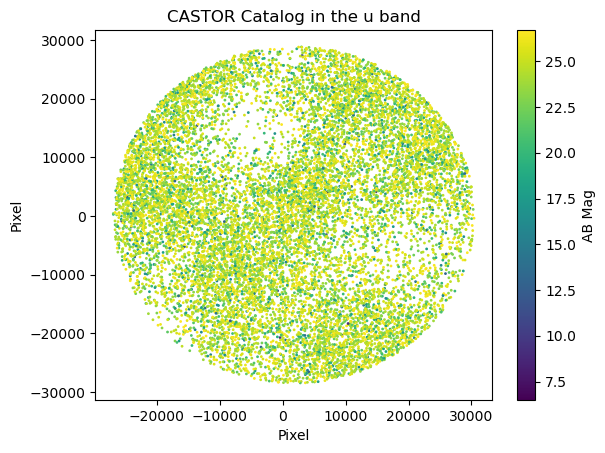

In [2]:
header = fits.Header({'NAXIS1': 2000,
       'NAXIS2': 2000,
       'NAXIS': 2,
       'CD1_1': 0.1/3600.0,
       'CD1_2': 0.0,
       'CD2_1': 0.0,
       'CD2_2': 0.1/3600.0,
       'CRPIX1': 1000.0,
       'CRPIX2': 1000.0,
       'CRVAL1': data['RA'].mean().to('degree').value,
       'CRVAL2': data['DEC'].mean().to('degree').value,
       'CTYPE1': 'RA---TAN',
       'CTYPE2': 'DEC--TAN',
})
from astropy.wcs import WCS
w = WCS(header)
data['x'], data['y'] = w.all_world2pix(data['RA'], data['DEC'], 0)
plt.scatter(data['x'], data['y'], c=data['CASTOR_u_app'], s=1)
# set a title and labels
plt.title('CASTOR Catalog in the u band')
plt.xlabel('Pixel')
plt.ylabel('Pixel')
plt.colorbar(label='AB Mag')

In [3]:
data['x'].shape, data['y'].shape, data['CASTOR_u_app'].shape

((48158,), (48158,), (48158,))

In [12]:
np.nanmedian(data['CASTOR_uv_app']), np.nanstd(data['CASTOR_uv_app']), np.nanmean(data['CASTOR_uv_app']), np.nanmax(data['CASTOR_uv_app']), np.nanmin(data['CASTOR_uv_app'])

(<Quantity 24.45719468>,
 <Quantity 2.65311495>,
 <Quantity 23.72002758>,
 <Quantity 26.69359821>,
 <Quantity 7.86164028>)

/var/folders/3w/spgmt8fj0t96y3xgc31682jm0000gn/T/ipykernel_1581/1612082840.py:6: DeprecationWarning: `photutils.CircularAperture` is a deprecated alias for `photutils.aperture.CircularAperture` and will be removed in the future. Instead, please use `from photutils.aperture import CircularAperture` to silence this warning.
  from photutils import CircularAperture


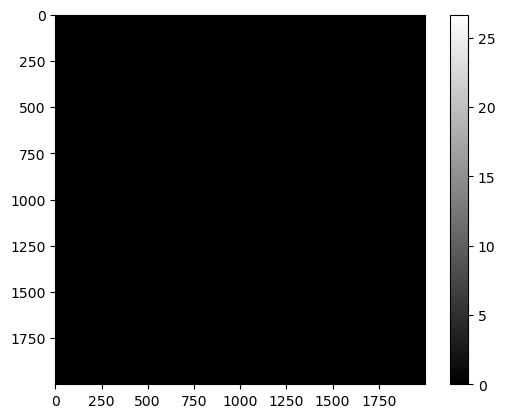

None 0.0 0.0 0.0


In [13]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.stats import sigma_clipped_stats
from photutils.detection import DAOStarFinder
from photutils import CircularAperture

# Open the fits file
hdu_list = fits.open('test.fits')

# Get the image data
image_data = hdu_list[0].data

# Replace NaNs with the median of valid data
image_data_clean = np.nan_to_num(image_data, nan=np.nanmedian(image_data))

# Plot the image
plt.imshow(image_data_clean, cmap='gray')
plt.colorbar()
plt.show()

# Calculate statistics for star detection
mean, median, std = sigma_clipped_stats(image_data_clean, sigma=3.0)

# Subtract the median for background removal
image_sub = image_data_clean - median

# Apply DAOStarFinder for star detection with adjusted threshold
daofind = DAOStarFinder(fwhm=3.0, threshold=2.*std)  # Reduced threshold to 2*std
sources = daofind(image_sub)

# If sources were detected, print and plot them
if sources is not None and len(sources) > 0:
    positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
    apertures = CircularAperture(positions, r=4.)
    
    # Plot the sources
    plt.imshow(image_data_clean, cmap='gray', origin='lower')
    apertures.plot(color='red', lw=1.5, alpha=0.5)
    plt.colorbar()
    plt.show()

# Print detected sources and the stats
print(sources, mean, median, std)


In [6]:
from photutils.detection import DAOStarFinder
from astropy.stats import sigma_clipped_stats

image_data = fits.getdata('test.fits')

np.nanmean(image_data),np.nanstd(image_data),np.nanmedian(image_data),np.nanmax(image_data),np.nanmin(image_data)



(0.000182059818497292, 0.06680365335628158, 0.0, 26.674771412148345, 0.0)

None 0.0 0.0 0.0


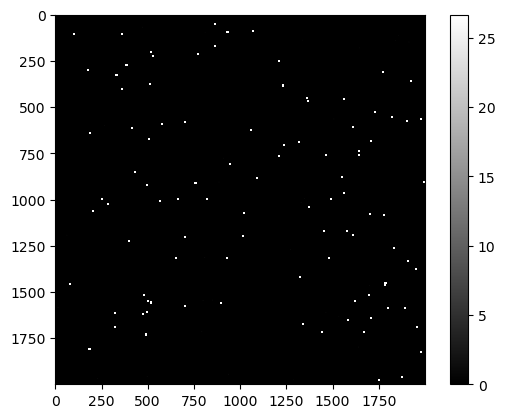

In [7]:
# open the fits file
hdu_list = fits.open('test.fits')

# get the image data
image_data = hdu_list[0].data

# plot the image
plt.imshow(image_data, cmap='gray')
plt.colorbar()


# section to find the stars
clip_image_data = np.clip(image_data,0,1000)
mean, median, std = sigma_clipped_stats(clip_image_data, sigma=3.0)

daofind = DAOStarFinder(fwhm=3.0, threshold=5.*std)
sources = daofind(clip_image_data - np.mean(clip_image_data))
print(sources,mean, median, std)

In [3]:
image_data.shape, np.nanmean(image_data), np.nanstd(image_data), np.nanmedian(image_data), np.nanmax(image_data), np.nanmin(image_data)

((2000, 2000),
 0.000182059818497292,
 0.06680365335628158,
 0.0,
 26.674771412148345,
 0.0)

In [15]:
# Replace NaN and Inf values in the image with zero or another suitable value
image_data_cleaned = np.nan_to_num(image_data, nan=0.0, posinf=0.0, neginf=0.0)

# Re-run sigma clipping and star detection on the cleaned image
mean, median, std = sigma_clipped_stats(image_data_cleaned, sigma=3.0)

# Initialize DAOStarFinder with adjusted parameters
daofind = DAOStarFinder(fwhm=3.0, threshold=5.*std, sharplo=0.1, sharphi=1.5, roundlo=-2.0, roundhi=2.0, peakmax=None)

# Subtract the median background from the cleaned image and detect sources
sources = daofind(image_data_cleaned - median)

# Check if sources are detected
if sources is None or len(sources) == 0:
    print("No sources found.")
else:
    print(sources)


 id xcentroid ycentroid     sharpness      ... sky        peak        flux mag 
--- --------- --------- ------------------ ... --- ------------------ ---- ----
  1     473.0      71.0 1.3729850022720946 ... 0.0 24.732387837341786  inf -inf
  2     811.0     101.0 1.3729850022720946 ... 0.0  18.48482304514089  inf -inf
  3    1855.0     115.0 1.3729850022720946 ... 0.0  19.06470769458148  inf -inf
  4    1336.0     141.0 1.3729850022720944 ... 0.0 22.423241998835003  inf -inf
  5    1839.0     142.0 1.3729850022720944 ... 0.0 24.960150147927834  inf -inf
  6    1913.0     151.0 1.3729850022720944 ... 0.0  24.83256582663303  inf -inf
  7    1644.0     183.0 1.3729850022720946 ... 0.0 26.345263209279466  inf -inf
  8     561.0     204.0 1.3729850022720946 ... 0.0 24.967809381849555  inf -inf
  9    1507.0     567.0 1.3729850022720946 ... 0.0 26.458524425434728  inf -inf
 10     266.0     602.0 1.3729850022720946 ... 0.0  23.61698196783525  inf -inf
...       ...       ...                .

/opt/anaconda3/lib/python3.11/site-packages/photutils/detection/daofinder.py:628: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)


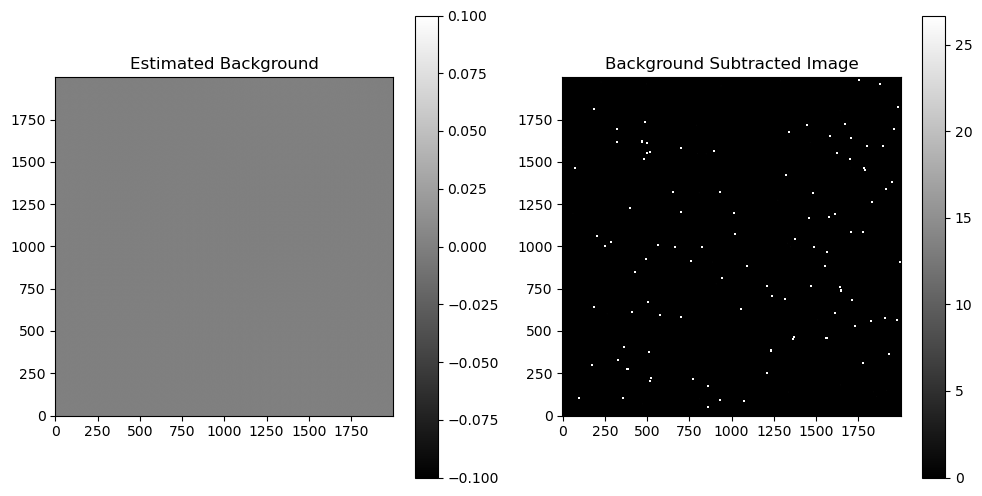

In [7]:
from astropy.stats import SigmaClip
from photutils.background import Background2D, MedianBackground
import matplotlib.pyplot as plt
import numpy as np

# Perform background estimation using sigma clipping
sigma_clip = SigmaClip(sigma=3.0)
bkg_estimator = MedianBackground()

# Adjust box_size and filter_size as per your image dimensions
bkg = Background2D(image_data, (50, 50), filter_size=(3, 3), sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)

# Subtract the background
image_data_cleaned = image_data - bkg.background

# Visualize the background and background-subtracted image
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(bkg.background, cmap='gray', origin='lower')
plt.colorbar()
plt.title('Estimated Background')

plt.subplot(1, 2, 2)
plt.imshow(image_data_cleaned, cmap='gray', origin='lower')
plt.colorbar()
plt.title('Background Subtracted Image')

plt.show()


In [10]:
# Compute the magnitudes for valid sources
valid_sources['mag'] = -2.5 * np.log10(valid_sources['flux'])

valid_sources 

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64
1,473.0,71.0,1.3729850022720946,0.0,0.0,25,0.0,24.732387837341786,inf,-inf
2,811.0,101.0,1.3729850022720946,0.0,0.0,25,0.0,18.48482304514089,inf,-inf
3,1855.0,115.0,1.3729850022720946,-1.5261961206281614e-17,0.0,25,0.0,19.06470769458148,inf,-inf
4,1336.0,141.0,1.3729850022720944,-2.595207501742328e-17,0.0,25,0.0,22.423241998835003,inf,-inf
5,1839.0,142.0,1.3729850022720944,2.3314349274293665e-17,0.0,25,0.0,24.960150147927834,inf,-inf
6,1913.0,151.0,1.3729850022720944,2.343413332920597e-17,0.0,25,0.0,24.83256582663303,inf,-inf
7,1644.0,183.0,1.3729850022720946,-2.2088587761105833e-17,0.0,25,0.0,26.345263209279466,inf,-inf
8,561.0,204.0,1.3729850022720946,0.0,0.0,25,0.0,24.967809381849555,inf,-inf
9,1507.0,567.0,1.3729850022720946,0.0,0.0,25,0.0,26.458524425434728,inf,-inf


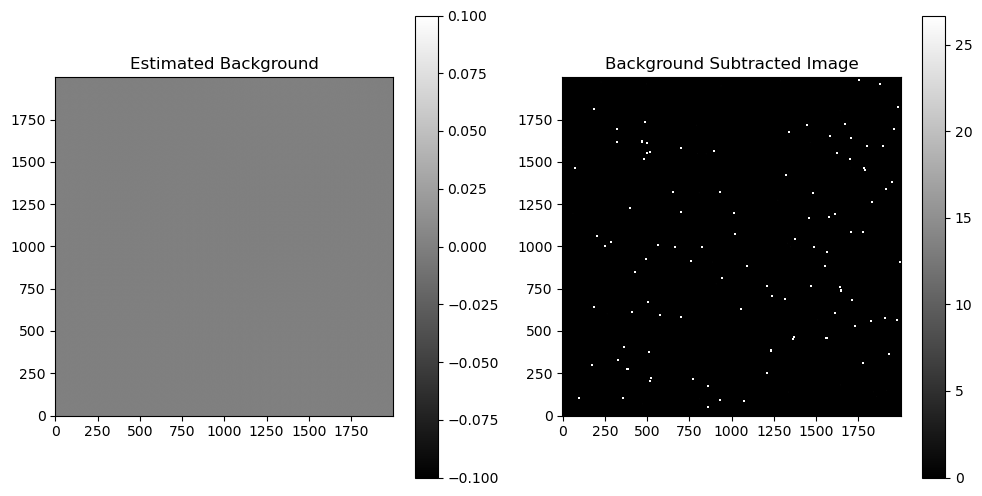

No sources detected.


/opt/anaconda3/lib/python3.11/site-packages/photutils/detection/irafstarfinder.py:475: RuntimeWarning: invalid value encountered in divide
  return np.sqrt(self.mu_diff**2


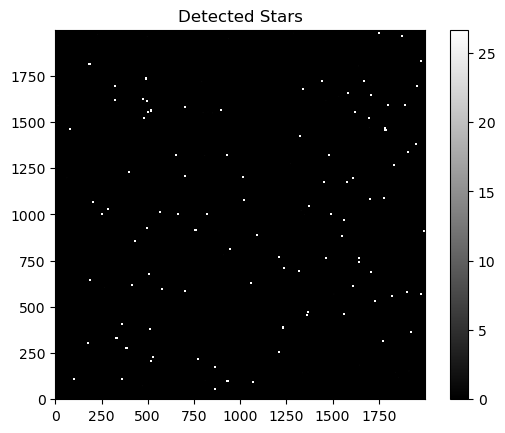

In [14]:
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from photutils.detection import IRAFStarFinder
from photutils.background import Background2D, MedianBackground
from astropy.stats import SigmaClip
import matplotlib.pyplot as plt
import numpy as np

# Load your image data (assuming it's a FITS file)
image_data = fits.getdata('test.fits')

# Perform background estimation using sigma clipping
sigma_clip = SigmaClip(sigma=3.0)
bkg_estimator = MedianBackground()

# Adjust box_size and filter_size as per your image dimensions
bkg = Background2D(image_data, (50, 50), filter_size=(3, 3), sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)

# Subtract the background from the image
image_data_cleaned = image_data - bkg.background

# Visualize the background and background-subtracted image
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(bkg.background, cmap='gray', origin='lower')
plt.colorbar()
plt.title('Estimated Background')

plt.subplot(1, 2, 2)
plt.imshow(image_data_cleaned, cmap='gray', origin='lower')
plt.colorbar()
plt.title('Background Subtracted Image')

plt.show()

# Perform sigma-clipped statistics on the cleaned image to estimate the noise
mean, median, std = sigma_clipped_stats(image_data_cleaned, sigma=3.0)

# Use IRAFStarFinder with suitable parameters
iraf_finder = IRAFStarFinder(
    threshold=3. * std,  # Detection threshold based on background noise
    fwhm=3.0,            # FWHM of the stars in the image (in pixels)
    sharplo=0.5,         # Lower bound on sharpness for detected stars
    sharphi=2.0,         # Upper bound on sharpness for detected stars
    roundlo=0.0,         # Lower bound on roundness
    roundhi=0.2,         # Upper bound on roundness
    minsep_fwhm=2.5,     # Minimum separation between detected stars
    peakmax=None         # No limit on the peak pixel value
)

# Detect stars using the IRAFStarFinder on the background-subtracted image
sources = iraf_finder(image_data_cleaned - median)

# Check if sources are detected
if sources is not None and len(sources) > 0:
    print(sources)
else:
    print("No sources detected.")

# Visualize the detected stars
plt.imshow(image_data_cleaned, cmap='gray', origin='lower')
plt.colorbar()
plt.title('Detected Stars')

# Overlay the detected stars
if sources is not None:
    plt.scatter(sources['xcentroid'], sources['ycentroid'], s=30, edgecolor='red', facecolor='none')
plt.show()


<h3> Converting the data from AB Mag to Flux </h3>

So Our Pyxel Model is used to taking values in Flux units. Preferably ADU. I will convert to Jansky first, and then convert to ADU.

(array([3.999872e+06, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.00

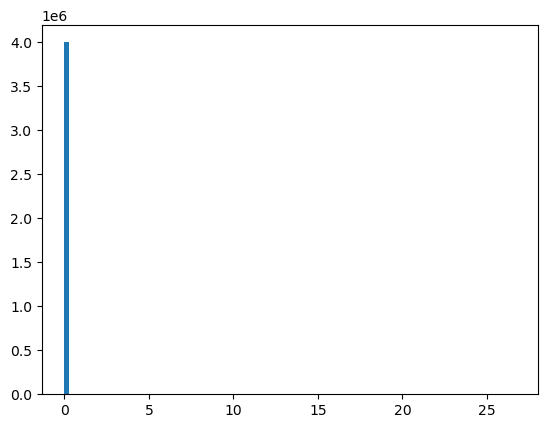

In [18]:
# getting the data from the test.fits file
vals = []
with fits.open("test.fits") as hdu2:
    section_data = hdu2[0].data
    # convert section_data to Jansky. Run a loop in the array that converts each pixel value to Jansky
    for i in range(len(section_data)):
        for j in range(len(section_data[i])):
            # check for nan values
            if np.isnan(section_data[i][j]):
                section_data[i][j] = 0
            else:
                vals.append(section_data[i][j])


# plot vals
plt.hist(vals, bins=100)

    
    # F/Jy = 10^(23-(AB+48.6)/2.5)))

In [19]:
section_data.shape
section_data[0][:]

array([0., 0., 0., ..., 0., 0., 0.], dtype='>f8')

In [4]:
import pyxel
config = pyxel.load("../config/u_band.yaml")

exposure = config.exposure
detector = config.detector
pipeline = config.pipeline

result = pyxel.run_mode(
    mode=exposure,
    detector=detector,
    pipeline=pipeline,
)
# for i in range(3):
#     print(np.nanmean(result["photon"][i]))

Readout time:   0%|          | 0/3 [00:00<?, ?it/s]

FileNotFoundError: [Errno 2] No such file or directory: '/Users/wasi/Desktop/SIP-CASTOR/Notebooks/test.fits'

In [ ]:
# crank the paraemters up and down convert the pictures to ADU.

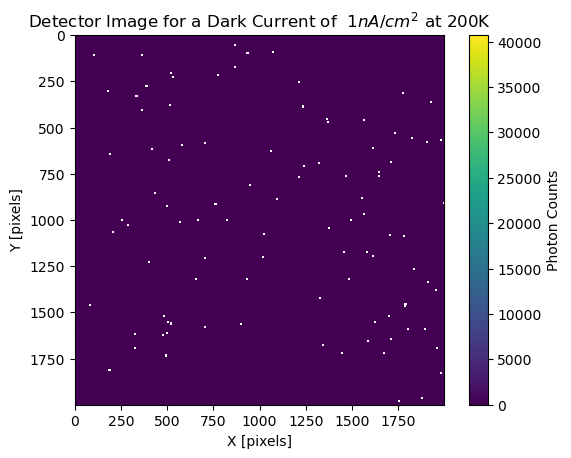

In [23]:
vals=result['photon'].to_numpy()

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.imshow(vals[2])
plt.title('Detector Image for a Dark Current of  $ 1 nA/cm^2$ at 200K')
plt.colorbar(label='Photon Counts')
plt.ylabel('Y [pixels]')
plt.xlabel('X [pixels]')
plt.show()



In [24]:
from photutils.detection import DAOStarFinder
from astropy.stats import sigma_clipped_stats

image_data = fits.getdata('test.fits')

np.nanmean(image_data)


0.000182059818497292